In [1]:
#========== Setup ==========
import jax, jax.numpy as jnp
from jax import random, vmap, value_and_grad, jit, grad, nn, jacrev
from jax.nn import relu, tanh, initializers
from jax.nn.initializers import variance_scaling, he_normal, he_uniform
import optax
from scipy.stats import qmc
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LightSource
from mpl_toolkits.mplot3d import Axes3D
import time

In [2]:
#========== Define functions and datasets ==========
def f_heaviside(x):
    return jnp.where((x >= 0.0) & (x <= 2.0), 1.0, 0.0)

def f_gamma(x):
    return jnp.sqrt(jnp.maximum(2.0 - x, 0.0))

def f_gaussians(x1, x2):
    k1, k2 = 1.0, 1.0
    #k1, k2 = 10, 10
    return jnp.exp(-(k1*(x1 - 0.5)**2 + (x2 - 0.5)**2)) + \
           jnp.exp(-(k2*(x1 + 0.5)**2 + (x2 + 0.5)**2))

def f_rosenbrock(x1, x2):
    return 100*(x2 - x1**2)**2 + (1-x1)**2

def f_gaussian_highdim(x):
    d = x.shape[-1]
    prefactor = 1 / (2 * jnp.pi)**(d / 2)
    return prefactor * jnp.exp(-jnp.sum(x**2, axis=-1))

datasets = {
    'heaviside': {
        'dim': 1,
        'domain': [(-2, 2)],
        'func': f_heaviside,
        'name': 'Heaviside'
    },
    'gamma': {
        'dim': 1,
        'domain': [(0, 2)],
        'func': f_gamma,
        'name': 'sqrt(2-x)'
    },
    'gaussians': {
        'dim': 2,
        'domain': [(-1, 1), (-1, 1)],
        'func': f_gaussians,
        'name': '2D Gaussians'
    },
    'rosenbrock': {
        'dim': 2,
        'domain': [(-2, 2), (-2, 2)],
        'func': f_rosenbrock,
        'name': 'Rosenbrock'
    }
}
#high_dim_ds = lambda d: {'f': f_gaussian_highdim, 'dim': d, 'domain': [(0, 1)]*d, 'name': f'High-d Gaussian (d={d})'}

def bounds(domain):
    lower = jnp.array([d[0] for d in domain])
    upper = jnp.array([d[1] for d in domain])
    return lower, upper

def generate_qmc_samples(dim, n, domain, seed=0):
    sampler = qmc.Sobol(d=dim, scramble=True, seed=seed)
    samples = sampler.random(n=n)
    lower, upper = bounds(domain)
    samples = lower + samples * (upper - lower)
    return jnp.array(samples)

def normalize(x, domain):
    lower, upper = bounds(domain)
    return 2 * (x - lower) / (upper - lower + 1e-10) - 1

In [3]:
# ========== Neural Network Architecture ==========
def initialize_mlp(sizes, key, activ_name):
    keys = random.split(key, len(sizes))

    def initialize_layer(m, n, k, activ_name):
        w_key, b_key = random.split(k)
        if activ_name == 'relu':
            initializer = he_uniform()  # He initialization for ReLU
            #initializer = he_normal()
        elif activ_name == 'tanh':
            initializer = variance_scaling(1.0, 'fan_avg', 'uniform')
            #initializer = glorot_uniform()
        else:
            raise ValueError("Unsupported activation.")
        W = initializer(w_key, (m, n))
        b = jnp.zeros((n,))
        return W, b

    return [initialize_layer(m, n, k, activ_name) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# Forward pass
def forward(params, acts, activation):
    for w, b in params[:-1]:
        acts = activation(jnp.dot(acts, w) + b)
    w, b = params[-1]
    return jnp.dot(acts, w) + b

# Predict function
def predict(params, x, activation):
    pred = vmap(lambda x_i: forward(params, x_i, activation))(x)
    return jnp.squeeze(pred, axis=-1) # Shape: (n_data,)

# Loss function
def loss(params, x, y, activation):
    y_pred = predict(params, x, activation)
    return jnp.mean(jnp.square(y_pred- y))


In [4]:
# ========== Training with optax (ADAM with scheduler) ==========
def train_model(x_train, y_train, sizes, activation, epochs=10000, lr=1e-3, batch_size=32, seed=0):
    key = random.PRNGKey(seed)
    params = initialize_mlp(sizes, key, activation)

    schedule = optax.polynomial_schedule(init_value=lr, end_value=lr * 0.1, power=2.0, transition_steps=1000 )
    # Set up optimizer in Optax
    optimizer = optax.adam(learning_rate=schedule)
    opt_state = optimizer.init(params)

    loss_grad = value_and_grad(loss, argnums=0)
    loss_history = []
    
    n_batches = len(x_train) // batch_size
    for epoch in range(epochs):
        epoch_loss = 0.0 
        perm = random.permutation(key, len(x_train))
        x_train = x_train[perm]
        y_train = y_train[perm]
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            x_batch = x_train[start:end]
            y_batch = y_train[start:end]
            loss_val, grads = loss_grad(params, x_batch, y_batch, activations[activ_name])
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            epoch_loss += loss_val
        loss_history.append(epoch_loss / n_batches)
        if epoch % 1000 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss_history[-1]:.6f}')
    return params, loss_history

In [ ]:
# ========== Main Execution ==========
start_time = time.time() # Start timing

architectures = {
    'shallow': lambda dim: [dim, 40, 1],  # Shallow network with one hidden layer
    'deep': lambda dim: [dim, 20, 20, 20, 1],  # Deep network with three hidden layers
}
activations = {
    'relu': nn.relu,
    'tanh': nn.tanh,
}



# Choose dataset
#selected_dataset = datasets['heaviside']
#selected_dataset = datasets['gamma']
selected_dataset = datasets['gaussians']
#selected_dataset = datasets['rosenbrock']

dim = selected_dataset['dim']
domain = selected_dataset['domain']
func = selected_dataset['func']
name = selected_dataset['name']

activ_name = 'tanh'  # 'relu' or 'tanh'
size = [dim, 20, 20, 20, 1]

data_points=100 if dim == 1 else 10000
test_points=100 if dim == 1 else 10000

x_data = generate_qmc_samples(dim, data_points, domain, seed=0)
x_test = generate_qmc_samples(dim, test_points, domain, seed=1)
x_test_norm = normalize(x_test, domain)

y_data = func(x_data[:, 0]) if dim == 1 else func(*x_data.T[:dim])
y_test = func(x_test[:, 0]) if dim == 1 else func(*x_test.T[:dim])

'''arch_shallow = [dim, 40, 1]         # 60 neurons total in hidden
arch_deep    = [dim, 20, 20, 20, 1] # 20*3 = 60 neurons total
for activ_name in ['relu','tanh']:
    for name, size in [('shallow', arch_shallow), ('deep', arch_deep)]:
        params, hist = train_model(x_test_norm, y_test, size, activ_name, epochs=10000, lr=1e-3)
        y_pred = predict(params, x_test_norm, activations[activ_name])'''

params, loss_history = train_model(x_test_norm, y_test, size, activ_name)
y_pred = predict(params, x_test_norm, activations[activ_name])

abs_err = jnp.abs(y_pred - y_test)
rel_err = abs_err / (jnp.abs(y_test) + 1e-10)

print(f"{name} - Mean Absolute Error: {jnp.mean(abs_err):.6f}, Mean Relative Error: {jnp.mean(rel_err):.6f}")

end_time = time.time()
print(f"Total Execution time: {end_time - start_time} seconds")   

/var/folders/4p/n57f6b3j7h16gj3ls6x3n6jr0000gn/T/ipykernel_99181/463704667.py:57: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = sampler.random(n=n)


Epoch [0/10000], Loss: 0.703716
Epoch [1000/10000], Loss: 0.000284
Epoch [2000/10000], Loss: 0.000005
Epoch [3000/10000], Loss: 0.000001
Epoch [4000/10000], Loss: 0.000001
Epoch [5000/10000], Loss: 0.000001
Epoch [6000/10000], Loss: 0.000001
Epoch [7000/10000], Loss: 0.000000
Epoch [8000/10000], Loss: 0.000001
Epoch [9000/10000], Loss: 0.000000
2D Gaussians - Mean Absolute Error: 0.000475, Mean Relative Error: 0.000647
Total Execution time: 939.452700138092 seconds


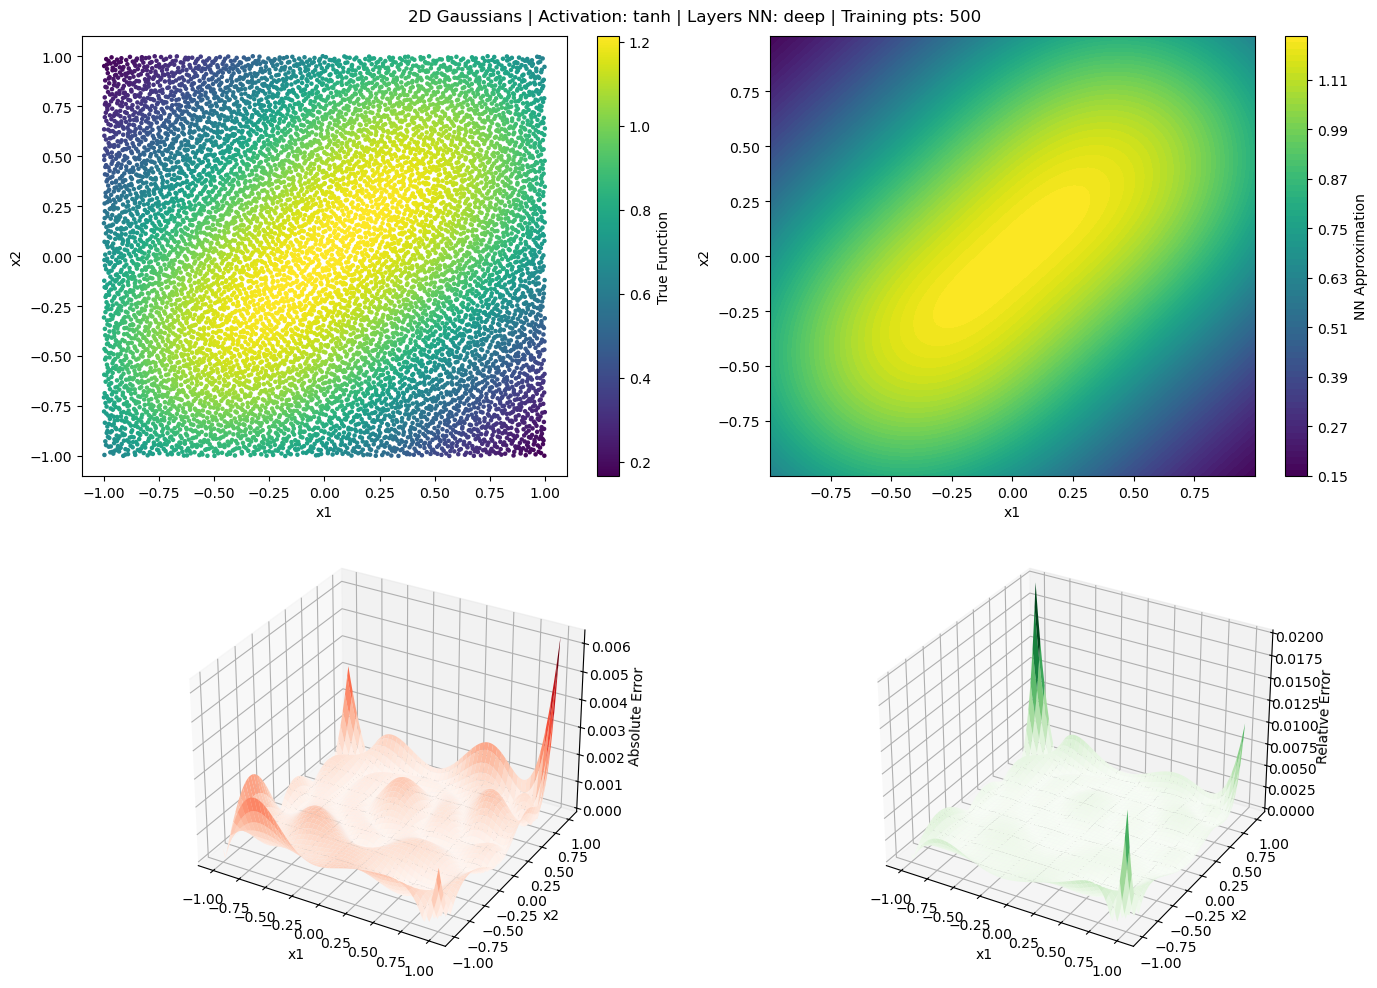

In [9]:
# ========== Visualization ==========
choice_arch = 'deep'# 'shallow' or 'deep'
choice_act = 'tanh' # 'relu' or 'tanh'

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
plt.rcParams.update({'font.size': 10}) 

if dim == 1:
        axes[0].scatter(x_data[:, 0], y_data, c='b', s=10, alpha=0.8, label='True')
        axes[0].set_xlabel('Data Points')
        axes[0].set_ylabel('True Function')
        axes[0].grid(True, alpha=0.3)

        axes[1].scatter(x_test[:, 0], y_pred, c='orange', s=10, alpha=0.8, label='NN Approx')
        axes[1].set_xlabel('Data Points')
        axes[1].set_ylabel('NN Approximation')
        axes[1].grid(True, alpha=0.3)

        axes[2].scatter(x_test[:, 0], abs_err, c='r', s=10, alpha=0.8)
        axes[2].set_xlabel('Data Points')
        axes[2].set_ylabel('Absolute Error')
        axes[2].grid(True, alpha=0.3)

        axes[3].scatter(x_test[:, 0], rel_err, c='g', s=10, alpha=0.8)
        axes[3].set_xlabel('Data Points')
        axes[3].set_ylabel('Relative Error')
        axes[3].grid(True, alpha=0.3)
else:
        x1, x2 = x_data[:, 0], x_data[:, 1]
        x1i, x2i = jnp.linspace(min(x1), max(x1), 100), jnp.linspace(min(x2), max(x2), 100)
        xi, xii = jnp.meshgrid(x1i, x2i)
        points = jnp.stack([xi.ravel(), xii.ravel()], axis=1)
        
        y_true_grid = func(points[:, 0], points[:, 1]).reshape(xi.shape) #griddata((x1, x2), y_data, (xi, xii), method='cubic')
        y_pred_grid = predict(params, points, activations[activ_name]).reshape(xi.shape) #((x_test[:, 0], x_test[:, 1]), y_pred, (xi, xii), method='cubic')
        
        abs_err_grid = jnp.abs(y_pred_grid - y_true_grid)
        rel_err_grid = abs_err_grid / (jnp.abs(y_true_grid) + 1e-10)
        
        cmap_true = 'viridis' if 'Gaussian' in name else 'plasma'

        axes[0].scatter(x1, x2, c=y_data, cmap='viridis' if name != 'Rosenbrock' else 'plasma', s=5)
        axes[0].set_xlabel('x1')
        axes[0].set_ylabel('x2')
        cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
        cbar.set_label('True Function', rotation=90)
        
        cont = axes[1].contourf(xi, xii, y_pred_grid, levels=100, cmap='viridis' if name != 'Rosenbrock' else 'plasma')
        axes[1].set_xlabel('x1')
        axes[1].set_ylabel('x2')
        cbar = plt.colorbar(cont, ax=axes[1])
        cbar.set_label('NN Approximation', rotation=90)
        
        '''axes[0].remove()
        axes[0] = fig.add_subplot(4, 4, 1, projection='3d')
        axes[0].plot_surface(xi, xii, y_true_grid, cmap=cmap_true, alpha=0.8)
        axes[0].set_xlabel('x1')
        axes[0].set_ylabel('x2')
        axes[0].set_zlabel('True Function')
        axes[0].grid(True, alpha=0.3)
        
        axes[1].remove()
        axes[1] = fig.add_subplot(2, 2, 2, projection='3d')
        axes[1].plot_surface(xi, xii, y_pred_grid, cmap=cmap_true, alpha=0.8)
        axes[1].set_xlabel('x1')
        axes[1].set_ylabel('x2')
        axes[1].set_zlabel('NN Approximation')
        axes[1].grid(True, alpha=0.3)'''
        
        axes[2].remove()
        axes[2] = fig.add_subplot(2, 2, 3, projection='3d')
        axes[2].plot_surface(xi, xii, abs_err_grid, cmap='Reds',linewidth=0, antialiased=True)
        axes[2].set_xlabel('x1')
        axes[2].set_ylabel('x2')
        axes[2].set_zlabel('Absolute Error')
        #axes[2].grid(True, alpha=0.3)

        axes[3].remove()
        axes[3] = fig.add_subplot(2, 2, 4, projection='3d')
        axes[3].plot_surface(xi, xii, rel_err_grid, cmap='Greens', linewidth=0, antialiased=True)
        axes[3].set_xlabel('x1')
        axes[3].set_ylabel('x2')
        axes[3].set_zlabel('Relative Error')
        axes[3].grid(True, alpha=0.3)

fig.suptitle(f"{name} | Activation: {choice_act} | Layers NN: {choice_arch} | Training pts: {test_points}")
plt.tight_layout()
plt.savefig(f"{name} | Activation: {choice_act} | Layers NN: {choice_arch} | Training pts: {test_points}", dpi=300)
plt.show()